# Exploratory Data Analysis 📁

In [1]:
import os
import pandas as pd 
from dotenv import load_dotenv
import requests
## -------------------------------------------------------------------------------------------------------------------- ##
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import levene
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL

## Data Loading

In [12]:
def get_noaa_data(token, datasetid, stationid, startdate, enddate, datatypeid):
    """ 
    Uses NOAA's API to retrieve climate data based on given parameters.
    Returns JSON data if successful.
    """
    url = "https://www.ncei.noaa.gov/cdo-web/api/v2/data"
    headers = {"token": token}
    params = {
        "datasetid": datasetid,
        "stationid": stationid,
        "startdate": startdate,
        "enddate": enddate,
        "datatypeid": datatypeid,
        "limit": 1000,
        "units": "metric"
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None

In [ ]:
# Get token
load_dotenv()
token = os.getenv("NOAA_TOKEN")

data = get_noaa_data(
    token=token,
    datasetid="GSOM",
    stationid="GHCND:USW00014989",
    startdate="2017-01-01",
    enddate="2024-12-31",
    datatypeid="TAVG"
)

In [ ]:
results = data.get("results", [])
df = pd.DataFrame(results)
df["date"] = pd.to_datetime(df["date"])
df["value"] = df["value"]/10
df.to_parquet("../Data/raw_data.parquet")

## Data Overview

In [ ]:
df = pd.read_parquet("../Data/raw_data.parquet")
print(df.shape)
df.info()


(90, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        90 non-null     datetime64[ns]
 1   datatype    90 non-null     object        
 2   station     90 non-null     object        
 3   attributes  90 non-null     object        
 4   value       90 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 3.6+ KB


In [ ]:
df.describe()

,date,value
count,90,90.000000
mean,2021-02-09 19:28:00,1.082778
min,2017-02-01 00:00:00,-0.790000
25%,2019-03-08 18:00:00,0.247500
50%,2021-03-16 12:00:00,1.040000
75%,2023-01-24 06:00:00,2.087500
max,2024-12-01 00:00:00,2.440000
std,NaN,0.980021


## Data Cleaning

In [ ]:
df = df.sort_values("date")

In [ ]:
df.set_index("date", inplace=True)

In [ ]:
df.isnull().sum()
df[df.isnull().any(axis=1)]

,datatype,station,attributes,value
date,,,,


In [ ]:
df = df["value"]*10

In [ ]:
df.rename("AverageTemperature")

date
2017-02-01     4.7
2017-03-01     6.1
2017-04-01    10.6
2017-05-01    15.9
2017-06-01    23.0
              ... 
2024-08-01    21.4
2024-09-01    19.9
2024-10-01    14.5
2024-11-01     5.3
2024-12-01     0.0
Name: AverageTemperature, Length: 90, dtype: float64

In [ ]:
df = df.to_frame()
df.to_parquet("../Data/clean_data.parquet")


## Univariate Analysis

In [2]:
serie = pd.read_parquet("../Data/clean_data.parquet")
serie = pd.Series(serie["value"], name="AverageTemperature")
serie.sample(5)

date
2018-01-01    -4.4
2021-09-01    20.0
2021-08-01    23.9
2019-10-01     7.7
2021-03-01     7.3
Name: AverageTemperature, dtype: float64

In [3]:
serie.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 90 entries, 2017-02-01 to 2024-12-01
Series name: AverageTemperature
Non-Null Count  Dtype  
--------------  -----  
90 non-null     float64
dtypes: float64(1)
memory usage: 1.4 KB


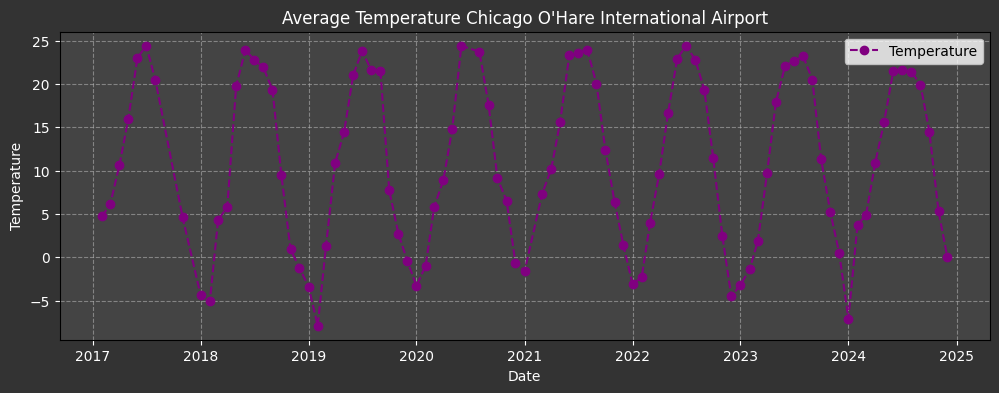

In [4]:
with plt.style.context('seaborn-v0_8-dark-palette'):
    fig, ax = plt.subplots(figsize=(12, 4), facecolor="#333333")  # Fondo de la figura
    ax.set_facecolor("#444444")

    ax.plot(serie, "o--", color="purple", label='Temperature')
    ax.set_title("Average Temperature Chicago O'Hare International Airport", color='white')
    ax.set_ylabel('Temperature', color='white')
    ax.set_xlabel('Date', color='white')
    ax.legend(loc='upper right')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(colors='white')

    plt.savefig('../Outputs/Figures/time_serie', facecolor=fig.get_facecolor())
    plt.show()

In [5]:
groups = [group.values for _, group in serie.resample('6ME') if len(group)>5]
stat, p_value = levene(*groups)
print(f"Levene's test statistic: {stat:.3f}, p-value: {p_value:.3f}")
if p_value < 0.05:
    print("HETEROSCEDASTICITY: the variances change every 6 months.")
else:
    print("HOMOSCEDASTICITY: the variance remains stable every 6 months.")

Levene's test statistic: 0.043, p-value: 1.000
HOMOSCEDASTICITY: the variance remains stable every 6 months.


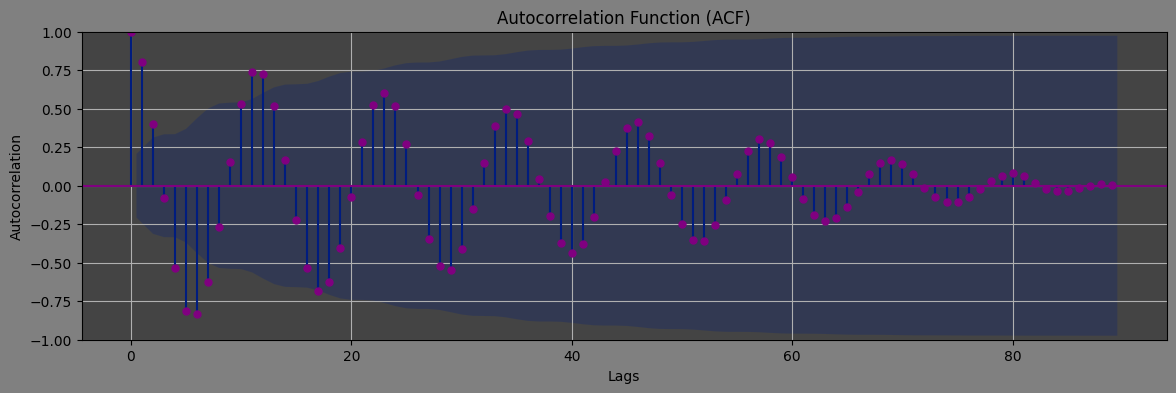

In [6]:
with plt.style.context('seaborn-v0_8-dark-palette'):
    fig, ax = plt.subplots(figsize=(14, 4), facecolor="gray")
    plot_acf(serie, color="purple", lags=89, ax=ax)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelation")
    ax.set_title("Autocorrelation Function (ACF)")
    ax.set_facecolor("#444444")
    plt.grid()
    plt.savefig("../Outputs/Figures/autocorrelation_function")
    plt.show()

In [7]:
result_adf = adfuller(serie)
print(f'Aumented Dickey-Fuller test statistic: {result_adf[0]:.3f}, p-value: {result_adf[1]:.3f}')
if result_adf[1] < 0.05:
    print("STATIONARY: the time series is stationary.")
else:
    print("NON-STATIONARY: the time series is not stationary. Differencing is needed.")
    serie_diff = serie.diff().dropna()

Aumented Dickey-Fuller test statistic: -8.915, p-value: 0.000
STATIONARY: the time series is stationary.


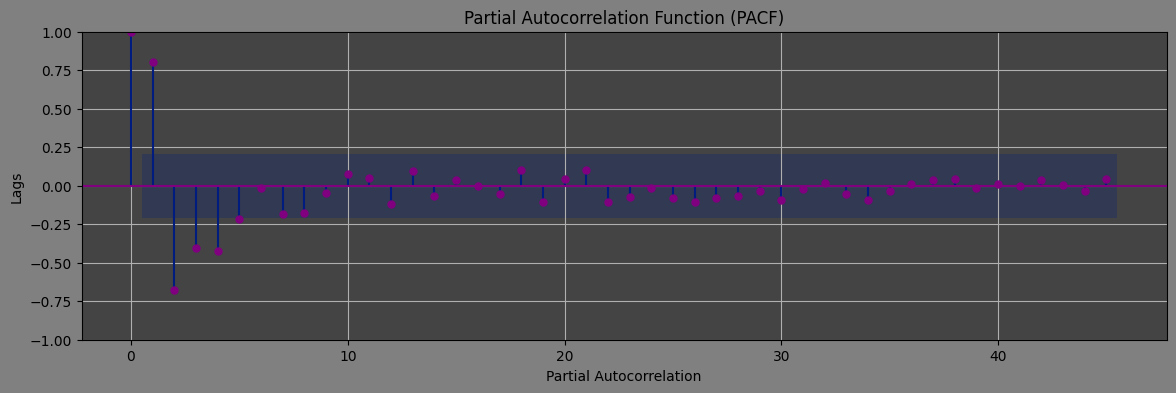

In [15]:
with plt.style.context("seaborn-v0_8-dark-palette"):
    fig, ax = plt.subplots(figsize=(14,4), facecolor="gray")
    plot_pacf(serie, color="purple", lags=45, ax=ax)
    ax.set_ylabel("Lags")
    ax.set_xlabel("Partial Autocorrelation")
    ax.set_title("Partial Autocorrelation Function (PACF)")
    ax.set_facecolor("#444444")
    plt.grid()
    plt.savefig("../Outputs/Figures/partial_autocorrelation_function")
    plt.show()
    

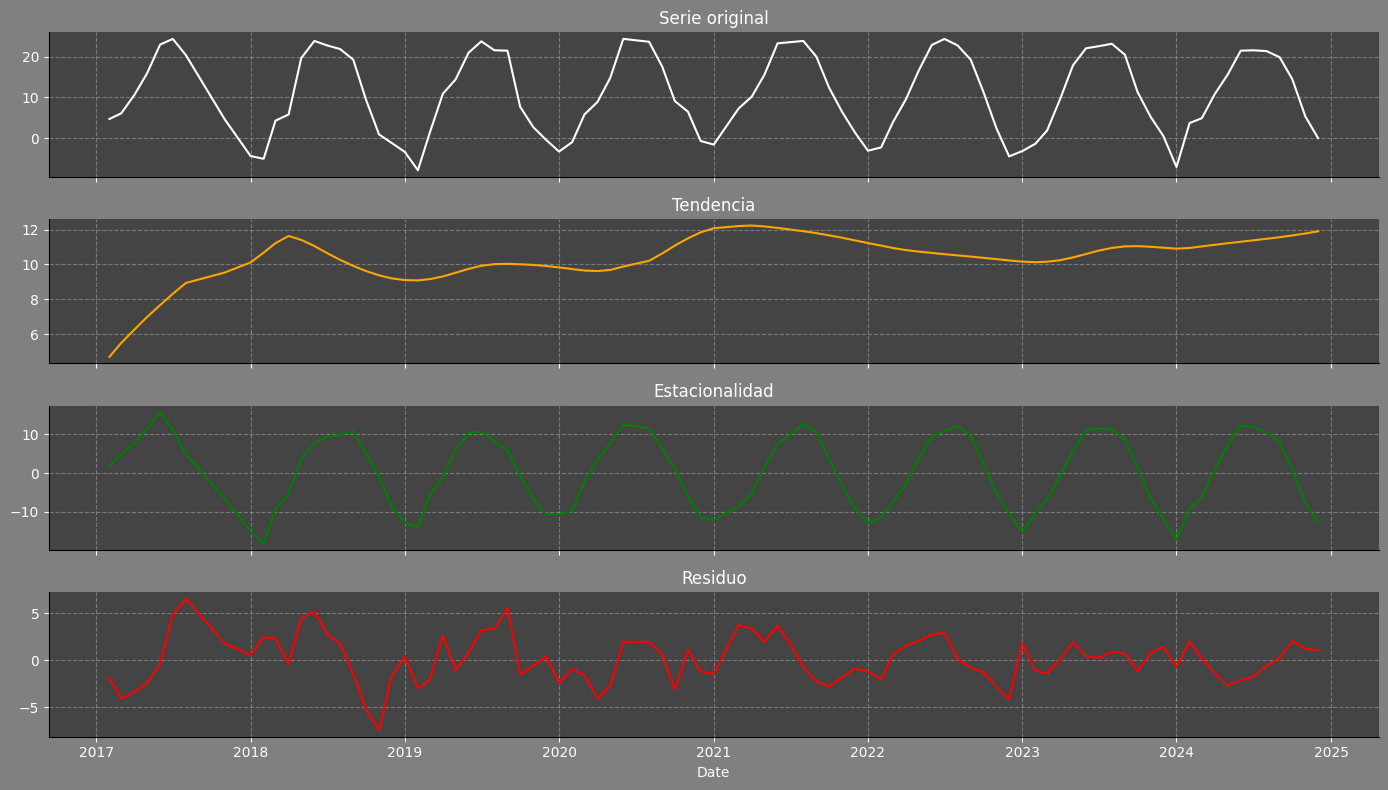

In [16]:
stl = STL(serie, period=12)
result = stl.fit()

with plt.style.context("seaborn-v0_8-dark-palette"):
    fig, axs = plt.subplots(4, 1, figsize=(14, 8), sharex=True, facecolor="gray")

    axs[0].plot(serie, color="white")
    axs[0].set_title("Serie original", color="white")

    axs[1].plot(result.trend, color="orange")
    axs[1].set_title("Tendencia", color="white")

    axs[2].plot(result.seasonal, color="green")
    axs[2].set_title("Estacionalidad", color="white")

    axs[3].plot(result.resid, color="red")
    axs[3].set_title("Residuo", color="white")
    axs[3].set_xlabel("Date", color="white")

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.tick_params(colors='white')
        ax.set_facecolor("#444444")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    fig.tight_layout()
    plt.savefig("../Outputs/Figures/stl_decomposition", facecolor="gray")
    plt.show()

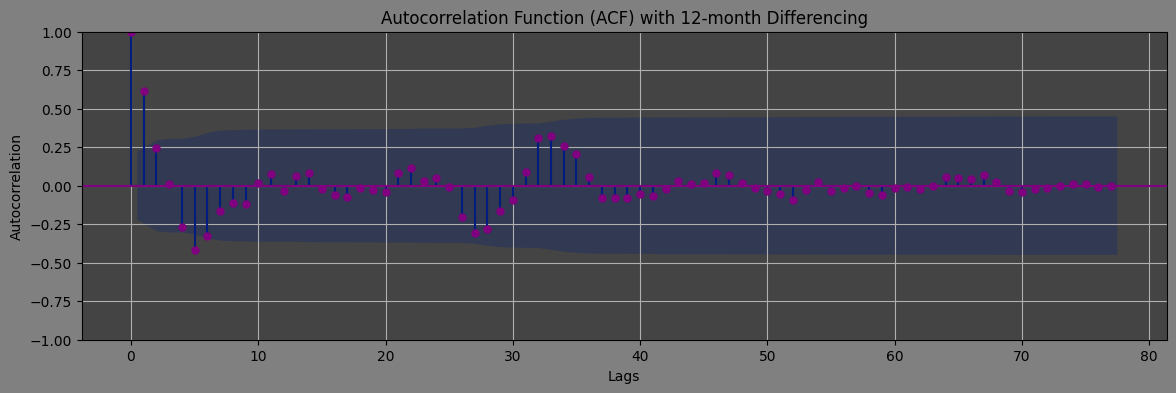

In [17]:
serie_diff_12 = serie.diff(12).dropna()
with plt.style.context('seaborn-v0_8-dark-palette'):
    fig, ax = plt.subplots(figsize=(14, 4), facecolor="gray")
    plot_acf(serie_diff_12, color="purple", lags=77, ax=ax)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelation")
    ax.set_title("Autocorrelation Function (ACF) with 12-month Differencing")
    ax.set_facecolor("#444444")
    plt.grid()
    plt.savefig("../Outputs/Figures/autocorrelation_function_with_12-month_differencing")
    plt.show()

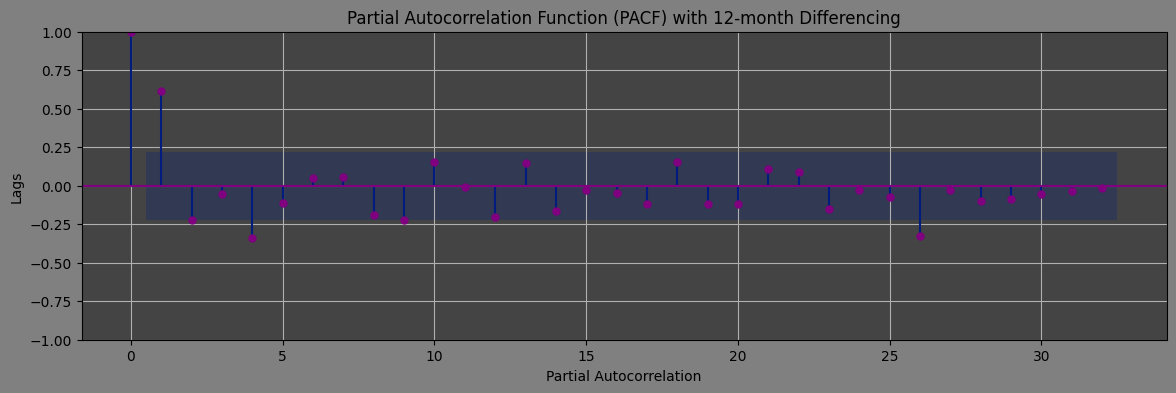

In [18]:
with plt.style.context("seaborn-v0_8-dark-palette"):
    fig, ax = plt.subplots(figsize=(14,4), facecolor="gray")
    plot_pacf(serie_diff_12, color="purple", lags=32, ax=ax)
    ax.set_ylabel("Lags")
    ax.set_xlabel("Partial Autocorrelation")
    ax.set_title("Partial Autocorrelation Function (PACF) with 12-month Differencing")
    ax.set_facecolor("#444444")
    plt.grid()
    plt.savefig("../Outputs/Figures/partial_autocorrelation_function_with_12-month_differencing")
    plt.show()

## Models

### Analysis after seasonal differencing (D=1, lag 12)

*   The ACF gradually decreases, with significant values at the first non-seasonal lags, indicating a possible AR process and some MA component.

*   The PACF shows strong significance at lags 1 and 2, then quickly drops off, suggesting that a non-seasonal AR(1) or AR(2) model is sufficient.

*   At seasonal lags (multiples of 12), no significant peaks appear in either the ACF or PACF, indicating there is no clear evidence for a seasonal AR component (P=0).

*   However, the seasonality is being captured by the seasonal differencing (D=1), which removes the repeating pattern to make the series stationary

### Therefore, the recommended SARIMA model structure is:
*   Non-seasonal part: (p=1, d=0, q=1) or simpler models based on results.

*   Seasonal part: (P=0, D=1, Q=0) with seasonal period 12.

### Suggested models to try:
*   SARIMA(1,0,1)(0,1,0)[12]

*   SARIMA(1,0,0)(0,1,0)[12]

*   SARIMA(0,0,1)(0,1,0)[12]